<a href="https://colab.research.google.com/github/AnshDhingraAD/EVOLVAI/blob/main/MODEL_PEC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached ultralytics-8.3.69-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-29 Python-3.11.11 torch-2.5.1+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 125MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


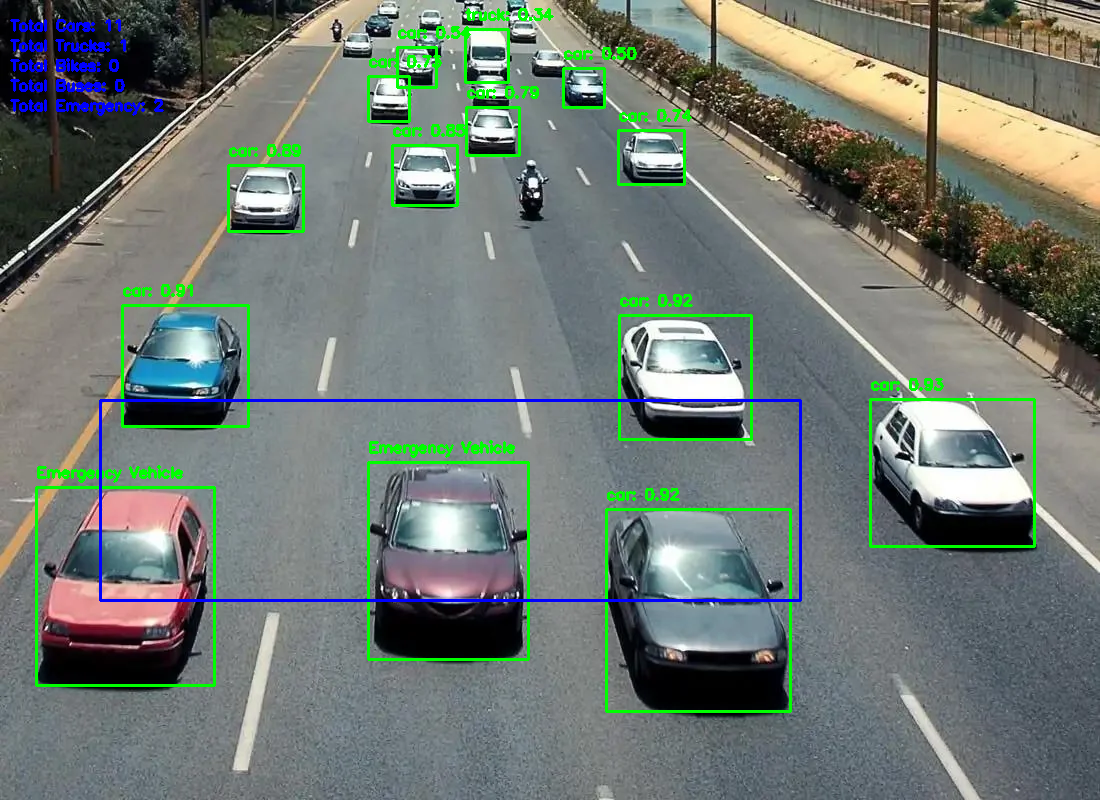

True

In [ ]:
!pip install ultralytics
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Path to the image
image_path = r"/content/why-dont-cars-drive-in-the-center-of-the-runway-are-they-v0-d92bzfmuqtkb1.webp"

# Read the image
frame = cv2.imread(image_path)

# Initialize counters for vehicle types
car_count = 0
truck_count = 0
bike_count = 0
bus_count = 0
emergency_count = 0
queue_length = 0  # Variable to count the queue length

# Define HSV color ranges for red and blue
red_lower1 = np.array([0, 50, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([170, 50, 50])
red_upper2 = np.array([180, 255, 255])

blue_lower = np.array([100, 150, 0])
blue_upper = np.array([140, 255, 255])

def detect_emergency_lights(roi):
    """Detect emergency lights (red and blue) in the given ROI."""
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Red mask
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Blue mask
    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

    # Find contours for red and blue masks
    red_contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check for significant red and blue regions
    red_detected = any(cv2.contourArea(c) > 200 for c in red_contours)  # Adjust area threshold
    blue_detected = any(cv2.contourArea(c) > 200 for c in blue_contours)

    return red_detected and blue_detected

# Perform inference
results = model(frame)

# Process the results
df = results.pandas().xyxy[0]  # Extract predictions as a DataFrame

# Define the region where you want to count vehicles for the queue (e.g., a traffic lane)
roi_top_left = (100, 400)  # Top-left corner of the ROI (modify these values based on the image)
roi_bottom_right = (800, 600)  # Bottom-right corner of the ROI (modify these values based on the image)

for index, row in df.iterrows():
    x1, y1, x2, y2, conf, cls = row[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']].values
    label = f'{model.names[int(cls)]}: {conf:.2f}'

    # Ensure minimum size for ROI
    if (x2 - x1) < 30 or (y2 - y1) < 30:
        continue  # Skip small detections

    # Extract the ROI for color detection
    roi = frame[int(y1):int(y2), int(x1):int(x2)]

    # Check if the detected object is a vehicle
    vehicle_type = model.names[int(cls)]
    if vehicle_type in ['car', 'truck', 'bus']:
        if detect_emergency_lights(roi):
            emergency_count += 1
            label = 'Emergency Vehicle'
        else:
            # Count vehicles based on class
            if vehicle_type == 'car':
                car_count += 1
            elif vehicle_type == 'truck':
                truck_count += 1
            elif vehicle_type == 'bus':
                bus_count += 1
    elif vehicle_type == 'motorcycle':
        bike_count += 1

    # Check if the bounding box is within the ROI for queue counting
    if x1 > roi_top_left[0] and y1 > roi_top_left[1] and x2 < roi_bottom_right[0] and y2 < roi_bottom_right[1]:
        queue_length += 1  # Increment queue length if the vehicle is in the defined region

    # Draw bounding box and label on the frame
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display vehicle counts on the frame
cv2.putText(frame, f'Total Cars: {car_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Trucks: {truck_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Bikes: {bike_count}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Buses: {bus_count}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Emergency: {emergency_count}', (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Draw the ROI on the image (optional, for visualization)
cv2.rectangle(frame, roi_top_left, roi_bottom_right, (255, 0, 0), 2)

# Show the image with detections using cv2_imshow
cv2_imshow(frame)

# Save the output image
output_path = r"/content/output_image.jpg"
cv2.imwrite(output_path, frame)


In [ ]:
import math

# Traffic data
print(f"Total Cars: {car_count}")
print(f"Total Trucks: {truck_count}")
print(f"Total Bikes: {bike_count}")
print(f"Total Buses: {bus_count}")
print(f"Total Emergency: {emergency_count}")
print(f"Queue Length: 0")

# Constants
k = 15  # Adjusted scaling factor for queue length
carWeight = 1.0
truckWeight = 3.0
busWeight = 2.75
bikeWeight = 0.65
maxGreenDuration = 120  # Maximum green light duration (seconds)
baseDuration = 15  # Minimum green light duration (seconds)

# Function to calculate the queue duration
def calculate_queue_duration(queue_length):
    """Piecewise scaling for queue duration to balance long and short queues."""
    if queue_length <= 10:
        return k * math.log(queue_length + 1)
    else:
        return 1.5 * k * math.log(queue_length + 1)

# Function to calculate the vehicle type duration
def calculate_vehicle_duration(car_count, truck_count, bus_count, bike_count):
    """Weighted sum of vehicle counts to account for different vehicle sizes."""
    return (car_count * carWeight) + (truck_count * truckWeight) + (bus_count * busWeight) + (bike_count * bikeWeight)

# Function to calculate the AQI impact
def calculate_aqi_impact(aqi):
    """Adjust green light duration based on AQI."""
    if aqi < 50:
        return 0.85  # Reduce by 15%
    elif 50 <= aqi <= 100:
        return 0.95  # Reduce by 5%
    elif 101 <= aqi <= 200:
        return 1.0  # No change
    elif 201 <= aqi <= 300:
        return 1.1  # Increase by 10%
    else:  # AQI > 300
        return 1.3  # Increase by 30%

# Function to calculate the emergency vehicle impact
def calculate_ev_impact(numEmergencyVehicles):
    """Prioritize emergency vehicles with logarithmic scaling."""
    return 1 + math.log(1 + numEmergencyVehicles)

# Main function to calculate the green light duration
def calculate_green_light_duration(queue_length, car_count, truck_count, bus_count, bike_count, aqi, numEmergencyVehicles):
    # Step 1: Calculate the queue duration
    queue_duration = calculate_queue_duration(queue_length)

    # Step 2: Calculate the vehicle type duration
    vehicle_duration = calculate_vehicle_duration(car_count, truck_count, bus_count, bike_count)

    # Step 3: Calculate the AQI impact
    aqi_impact = calculate_aqi_impact(aqi)

    # Step 4: Calculate the emergency vehicle impact
    ev_impact = calculate_ev_impact(numEmergencyVehicles)

    # Step 5: Dynamic weight adjustment based on queue length
    if queue_length > 10:
        w1, w2 = 0.7, 0.3  # Higher weight for queue length
    else:
        w1, w2 = 0.5, 0.5  # Balanced weight for smaller queues

    # Step 6: Combine factors to calculate the green light duration
    weighted_duration = (w1 * queue_duration + w2 * vehicle_duration) * aqi_impact * ev_impact
    green_light_duration = min(maxGreenDuration, max(baseDuration, weighted_duration))

    return green_light_duration

# Example Input Data
aqi = 130  # Air Quality Index
emergency_count = 0  # Number of emergency vehicles present

# Calculate the green light duration
green_light_duration = calculate_green_light_duration(queue_length, car_count, truck_count, bus_count, bike_count, aqi, emergency_count)

# Output the result
print(f"Optimized Green Light Duration: {green_light_duration:.2f} seconds")


Total Cars: 11
Total Trucks: 1
Total Bikes: 0
Total Buses: 0
Total Emergency: 2
Queue Length: 0
Optimized Green Light Duration: 15.00 seconds


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-29 Python-3.11.11 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Enter the image path for Lane 1: /content/an-ambulance-goes-to-a-serious-traffic-accident-in-herne-germany-on-GFATEM.jpg
Enter the image path for Lane 2: /content/traffic-road-highway-way-busy-cars.jpg
Enter the image path for Lane 3: /content/traffic.jpg
Enter the image path for Lane 4: /content/why-dont-cars-drive-in-the-center-of-the-runway-are-they-v0-d92bzfmuqtkb1.webp


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Traffic Light Results (Sorted by Priority):

Lane 1: GREEN for 32.84 seconds


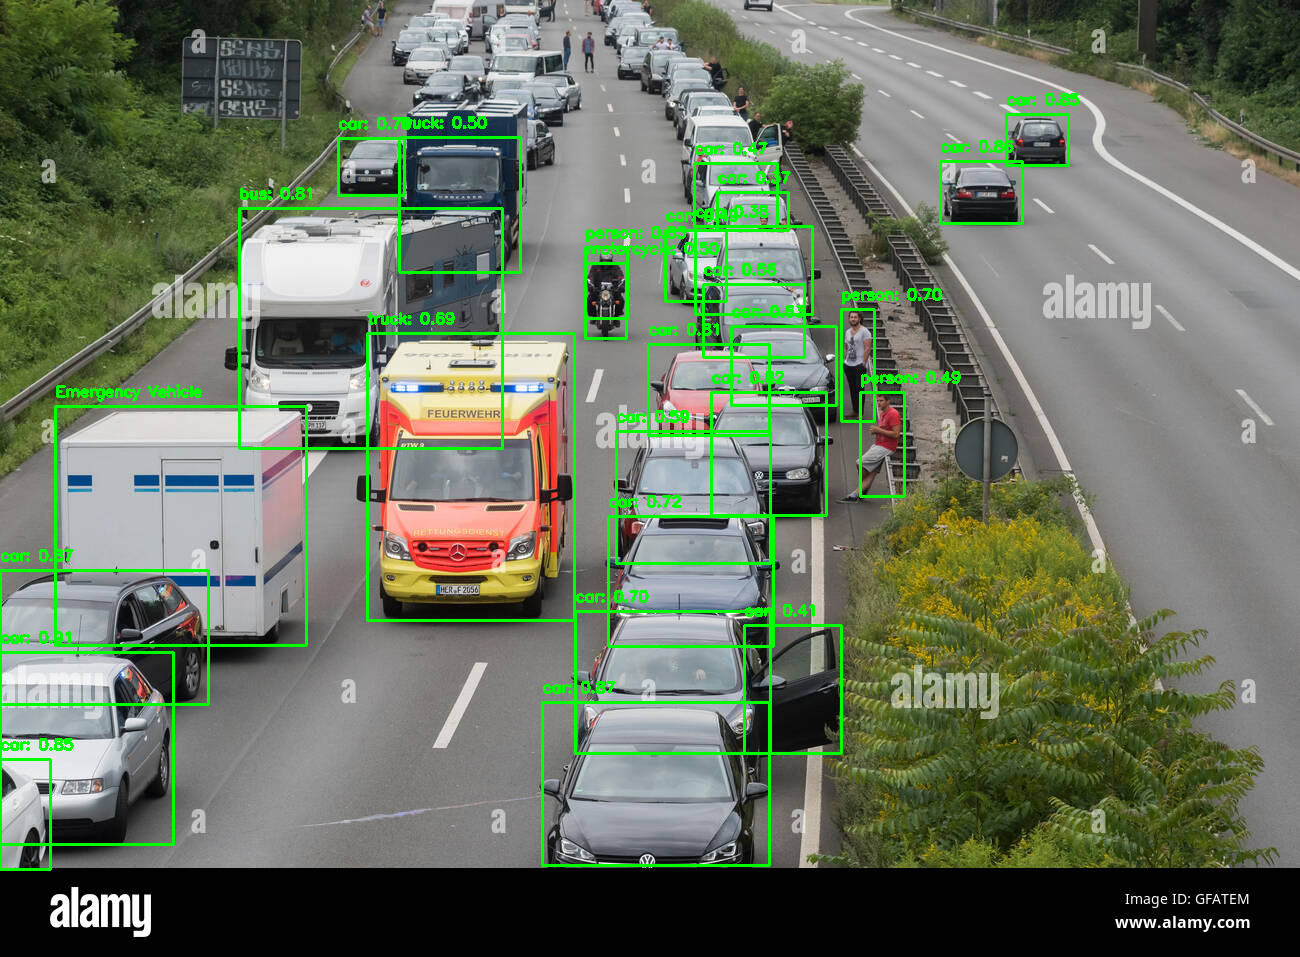

Lanes held RED while Lane 1 is GREEN:
  Lane 2: RED
  Lane 3: RED
  Lane 4: RED


Lane 2: GREEN for 32.51 seconds


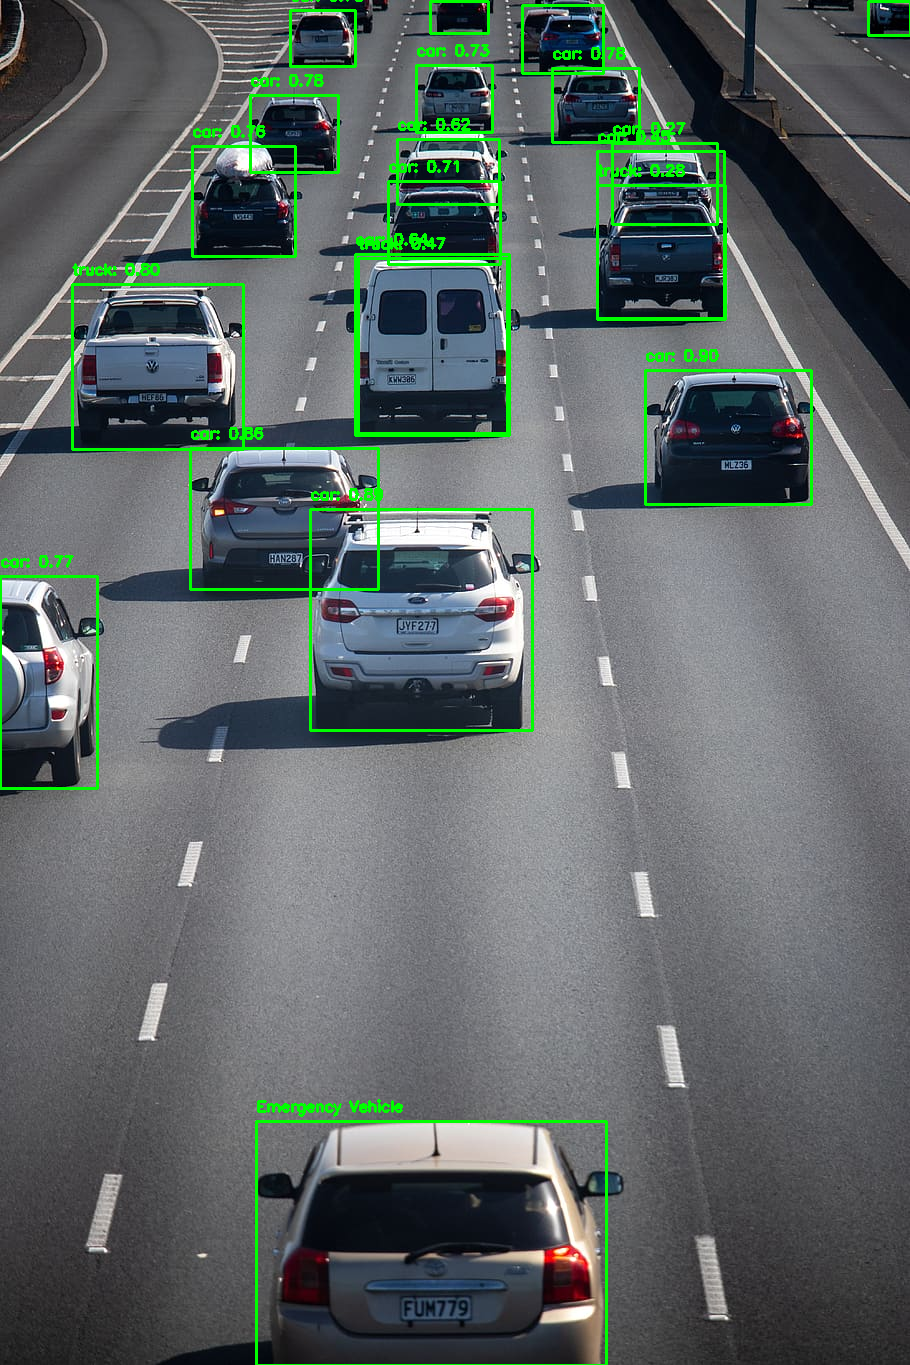

Lanes held RED while Lane 2 is GREEN:
  Lane 1: RED
  Lane 3: RED
  Lane 4: RED


Lane 4: GREEN for 15.00 seconds


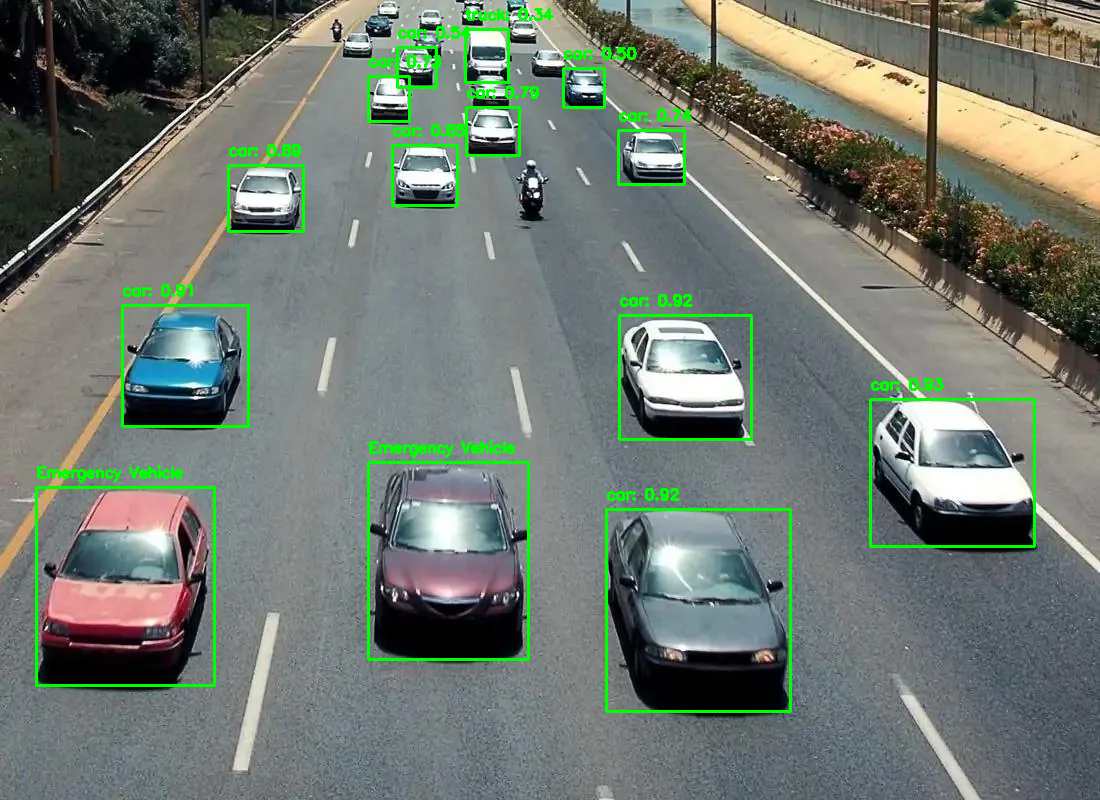

Lanes held RED while Lane 4 is GREEN:
  Lane 1: RED
  Lane 2: RED
  Lane 3: RED


Lane 3: GREEN for 25.27 seconds


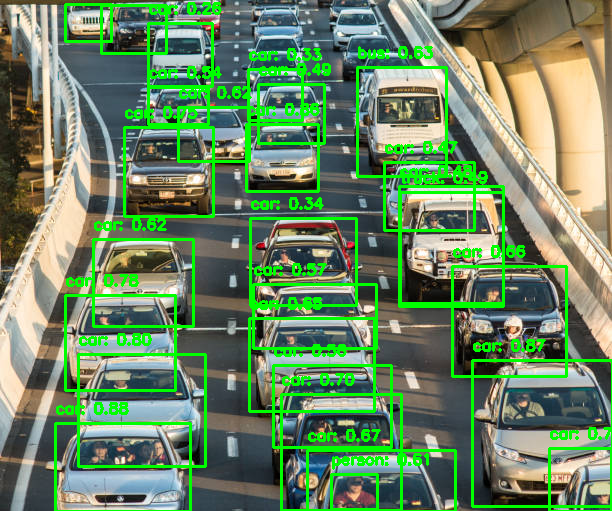

Lanes held RED while Lane 3 is GREEN:
  Lane 1: RED
  Lane 2: RED
  Lane 4: RED




In [ ]:
import torch
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Constants
k = 15  # Scaling factor for queue length
carWeight = 1.0
truckWeight = 3.0
busWeight = 2.75
bikeWeight = 0.65
maxGreenDuration = 120  # Maximum green light duration (seconds)
baseDuration = 15  # Minimum green light duration (seconds)

# Define HSV color ranges for red and blue (emergency lights)
red_lower1 = np.array([0, 50, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([170, 50, 50])
red_upper2 = np.array([180, 255, 255])
blue_lower = np.array([100, 150, 0])
blue_upper = np.array([140, 255, 255])

def detect_emergency_lights(roi):
    """Detect emergency lights (red and blue) in the given ROI."""
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Red mask
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Blue mask
    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

    # Find contours for red and blue masks
    red_contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check for significant red and blue regions
    red_detected = any(cv2.contourArea(c) > 200 for c in red_contours)  # Adjust area threshold
    blue_detected = any(cv2.contourArea(c) > 200 for c in blue_contours)

    return red_detected and blue_detected

def process_lane_image(image_path):
    """Process a single lane image to count vehicles and detect emergency vehicles."""
    # Read the image
    frame = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if frame is None:
        print(f"Error: Could not read image at path: {image_path}")
        return None, 0, 0, 0, 0, 0, 0  # Return default values if image loading fails

    # Initialize counters for vehicle types
    car_count = 0
    truck_count = 0
    bike_count = 0
    bus_count = 0
    emergency_count = 0
    queue_length = 0  # Variable to count the queue length

    # Perform inference with YOLOv5
    results = model(frame)
    df = results.pandas().xyxy[0]  # Extract predictions as a DataFrame

    # Define the region where you want to count vehicles for the queue (e.g., a traffic lane)
    roi_top_left = (100, 400)  # Top-left corner of the ROI (modify these values based on the image)
    roi_bottom_right = (800, 600)  # Bottom-right corner of the ROI (modify these values based on the image)

    for index, row in df.iterrows():
        x1, y1, x2, y2, conf, cls = row[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']].values
        label = f'{model.names[int(cls)]}: {conf:.2f}'

        # Ensure minimum size for ROI
        if (x2 - x1) < 30 or (y2 - y1) < 30:
            continue  # Skip small detections

        # Extract the ROI for color detection
        roi = frame[int(y1):int(y2), int(x1):int(x2)]

        # Check if the detected object is a vehicle
        vehicle_type = model.names[int(cls)]
        if vehicle_type in ['car', 'truck', 'bus']:
            if detect_emergency_lights(roi):
                emergency_count += 1
                label = 'Emergency Vehicle'
            else:
                # Count vehicles based on class
                if vehicle_type == 'car':
                    car_count += 1
                elif vehicle_type == 'truck':
                    truck_count += 1
                elif vehicle_type == 'bus':
                    bus_count += 1
        elif vehicle_type == 'motorcycle':
            bike_count += 1

        # Check if the bounding box is within the ROI for queue counting
        if x1 > roi_top_left[0] and y1 > roi_top_left[1] and x2 < roi_bottom_right[0] and y2 < roi_bottom_right[1]:
            queue_length += 1  # Increment queue length if the vehicle is in the defined region

        # Draw bounding box and label on the frame
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return frame, car_count, truck_count, bike_count, bus_count, emergency_count, queue_length

def calculate_green_light_duration(queue_length, car_count, truck_count, bus_count, bike_count, aqi, emergency_count):
    """Calculate the green light duration for a lane based on queue, vehicle types, and AQI."""
    # Calculate the queue duration
    queue_duration = k * math.log(queue_length + 1) if queue_length <= 10 else 1.5 * k * math.log(queue_length + 1)

    # Calculate the vehicle type duration
    vehicle_duration = (car_count * carWeight) + (truck_count * truckWeight) + (bus_count * busWeight) + (bike_count * bikeWeight)

    # Calculate AQI impact
    if aqi < 50:
        aqi_impact = 0.85
    elif 50 <= aqi <= 100:
        aqi_impact = 0.95
    elif 101 <= aqi <= 200:
        aqi_impact = 1.0
    elif 201 <= aqi <= 300:
        aqi_impact = 1.1
    else:
        aqi_impact = 1.3

    # Calculate emergency vehicle impact
    ev_impact = 1 + math.log(1 + emergency_count)

    # Dynamic weight adjustment
    w1, w2 = (0.7, 0.3) if queue_length > 10 else (0.5, 0.5)

    # Combine factors to calculate the green light duration
    weighted_duration = (w1 * queue_duration + w2 * vehicle_duration) * aqi_impact * ev_impact
    green_light_duration = min(maxGreenDuration, max(baseDuration, weighted_duration))

    return green_light_duration

# Main Program
lane_images = {}  # Store lane image paths
lane_results = {}  # Store results for each lane

# Get image inputs for 4 lanes
for lane in range(1, 5):
    image_path = input(f"Enter the image path for Lane {lane}: ")
    lane_images[lane] = image_path

# Example AQI
aqi = 130  # Example AQI value

# Process all lanes
for lane, image_path in lane_images.items():
    frame, car_count, truck_count, bike_count, bus_count, emergency_count, queue_length = process_lane_image(image_path)

    # Calculate the green light duration for this lane
    green_duration = calculate_green_light_duration(queue_length, car_count, truck_count, bus_count, bike_count, aqi, emergency_count)

    # Store lane data
    lane_results[lane] = {
        "green_duration": green_duration,
        "emergency_count": emergency_count,
        "vehicle_counts": {"car": car_count, "truck": truck_count, "bike": bike_count, "bus": bus_count},
        "output_image": frame
    }

# Sort lanes based on emergency vehicle presence first, then by vehicle density
sorted_lanes = sorted(lane_results.items(), key=lambda x: (x[1]["emergency_count"] == 0, -x[1]["green_duration"]))

# Display results
print("\nTraffic Light Results (Sorted by Priority):\n")
for i, (lane, data) in enumerate(sorted_lanes):
    green_duration = data["green_duration"]
    print(f"Lane {lane}: GREEN for {green_duration:.2f} seconds")

    # Display image for this lane
    cv2_imshow(data["output_image"])

    # Show other lanes held red
    print(f"Lanes held RED while Lane {lane} is GREEN:")
    for other_lane in lane_images.keys():
        if other_lane != lane:
            print(f"  Lane {other_lane}: RED")

    print("\n" + "="*50 + "\n")  # Separator for clarity

